In [13]:
import numpy as np
from simulation import *
import sys
sys.path.append('../virtuallab/tools')
from filmstack_visualization import plot_tmm_filmstack

meterial = meterial_s
def make_film(nk, depth):
    m = meterial()
    m.nk = nk
    m.depth = depth
    return m
degree = np.pi/180

In [14]:
f = {
    "TE":{
        "interface_matrix":TMM_interface_transfer_matrix_with_thickness_without_multiply_s,
        "apply_multilayer_effect":TMM_apply_multilayer_effect,
        "TMM" : TMM_interface_transfer_matrix_with_thickness_s,
        "e_field":TMM_get_e_field_s,
    },
    "TM":{
        "interface_matrix":TMM_interface_transfer_matrix_with_thickness_without_multiply_p,
        "apply_multilayer_effect":TMM_apply_multilayer_effect,
        "TMM" : TMM_interface_transfer_matrix_with_thickness_p,
        "e_field":TMM_get_e_field_p,
    }
}
def c_matrix_to_np(m):
    r0, r1 = m
    a00, a01 = r0
    a10, a11 = r1
    return np.array([[a00, a01],[a10, a11]])
def get_forwad_backward_list(tmm_list, interface_list):
    r, t = TMM_get_r_t_from_tmm(tmm_list[-1])
    vw = np.array([[t],[0]])
    vw_list = np.zeros((len(interface_list) + 1, 2), dtype=complex)
    vw_list[-1,:] = np.transpose(vw)
    # vw_list[0, :] = np.transpose([1, r])
    for i in range(len(vw_list)-2, -1, -1):
        M = c_matrix_to_np(interface_list[i])
        temp = np.dot(M, vw)
        vw = temp
        vw_list[i,:] = np.transpose(vw)
    assert(np.abs(1 - vw_list[0,0]) < 1e-6)
    assert(np.abs(r - vw_list[0,1]) < 1e-6)

    return vw_list
def OB_AR625_655(wl_0=532, angle=0):
    th_0 = angle * degree

    # upper
    air = meterial()
    air.nk = 1
    # substrate
    Si = meterial()
    Si.nk = 1.4607

    # film stack
    SiO2_nk = 1.4621 + 1.4254e-5j
    Ta2O5_nk= 2.1548 + 0.00021691j
    nk_list =[SiO2_nk, Ta2O5_nk, SiO2_nk, Ta2O5_nk, SiO2_nk]
    thickness_list = [247.35, 16.99, 276.02, 43.96, 128.74]
    film_list = [make_film(n, d) for n, d in zip(nk_list, thickness_list)]
    
    input = [air]
    for film in reversed(film_list):
        input.append(film)
    input.append(Si)
    plot_tmm_filmstack(input, ["air", "SiO2", "Ta2O5", "SiO2", "Ta2O5", "SiO2", "Si"], angle_deg=angle, visual_width = -1)
    dir = TMM_propagate_direction(input, th_0)
    # print([x/degree for x in dir])
    TE = f["TE"]
    TM = f["TM"]
    tmm_s = TE["TMM"](input, dir, wl_0)
    tmm_p = TM["TMM"](input, dir, wl_0)

    wave_on_interface_s = get_forwad_backward_list(tmm_s, TE["interface_matrix"](input, dir, wl_0))
    # print(wave_on_interface_s)
    wave_on_interface_p = get_forwad_backward_list(tmm_p, TM["interface_matrix"](input, dir, wl_0))
    # print(wave_on_interface_p)
    forward_flag, backward_flag = 0, 1

    first_interface = 0
    e_field_reflection_s = TE["e_field"](0, wave_on_interface_s[first_interface][backward_flag])
    e_field_reflection_p = TM["e_field"](0, wave_on_interface_p[first_interface][backward_flag], dir[first_interface])

    last_interface = -1
    e_field_transmition_s = TE["e_field"](wave_on_interface_s[last_interface][forward_flag], 0)
    e_field_transmition_p = TM["e_field"](wave_on_interface_p[last_interface][forward_flag], 0, dir[last_interface])

    print(f"* test with wavelength={wl_0}, incidence={angle}")
    print("(E field)     \tTE\tTM")
    print(f"Reflectance  \t{e_field_reflection_s}\t{e_field_reflection_p}")
    print(f"Transmittance\t{e_field_transmition_s}\t{e_field_transmition_p}")


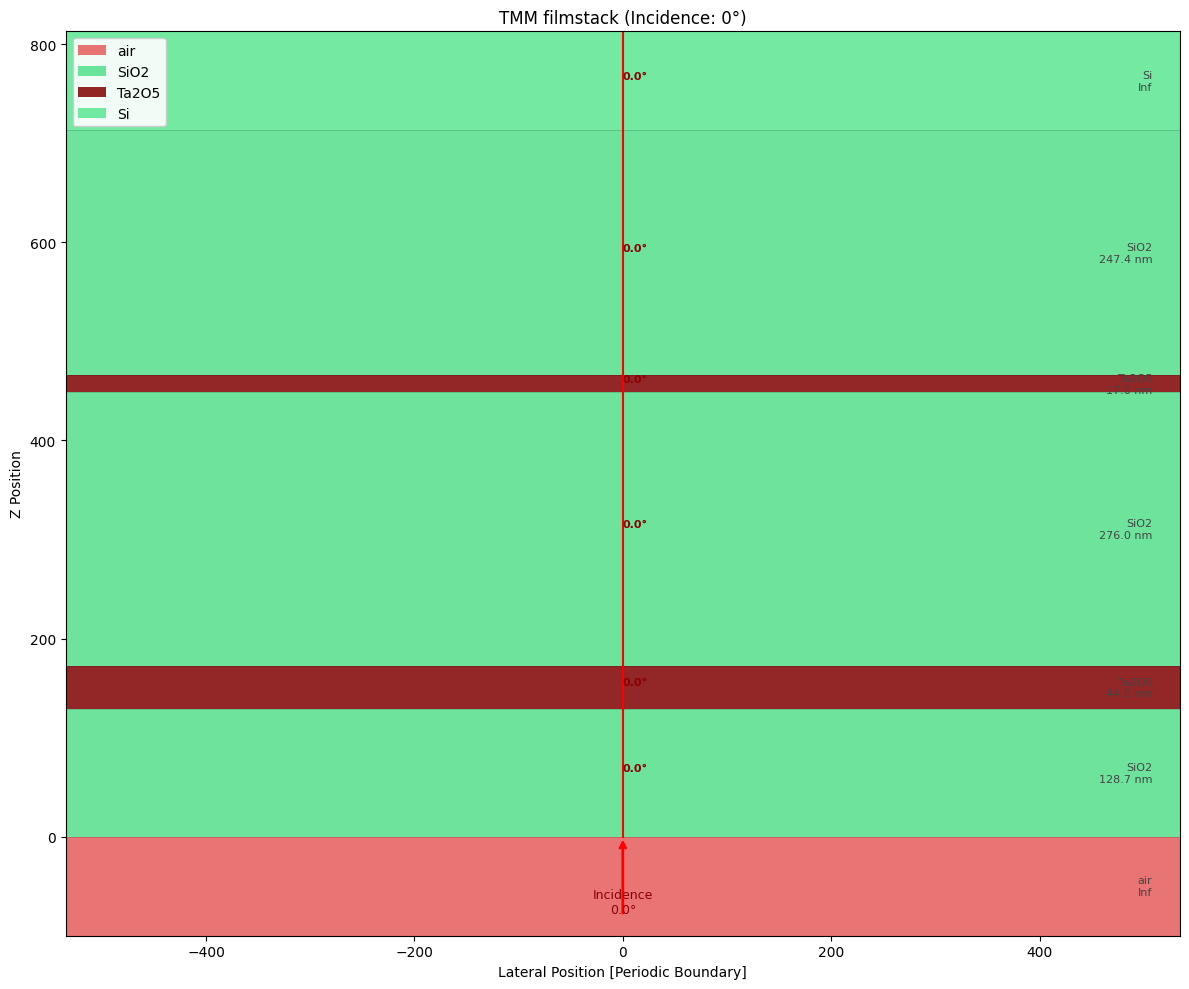

* test with wavelength=532, incidence=0
(E field)     	TE	TM
Reflectance  	[(0,0),(0.156601,0.211243),(0,0)]	[(0.156601,0.211243),(0,0),(0,0)]
Transmittance	[(0,0),(0.736575,0.307018),(0,0)]	[(0.736575,0.307018),(0,0),(0,-0)]


In [15]:
# TODO : 找一个 baseline 进行对比
OB_AR625_655(wl_0 = 532, angle = 0)

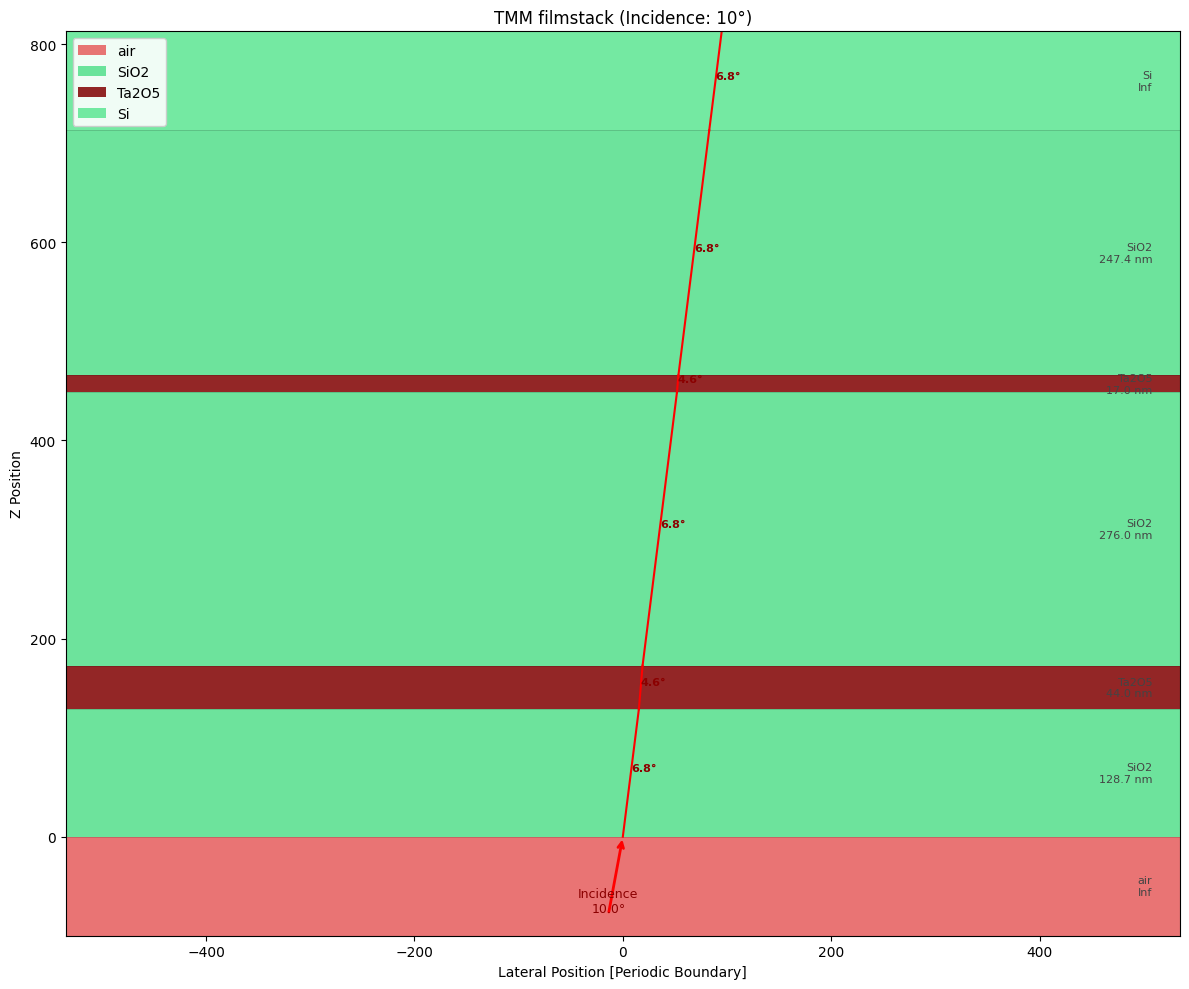

* test with wavelength=532, incidence=10
(E field)     	TE	TM
Reflectance  	[(0,0),(0.158243,0.190671),(0,0)]	[(0.157726,0.182188),(0,0),(0.0278113,0.0321247)]
Transmittance	[(0,0),(0.760047,0.2433),(0,0)]	[(0.75688,0.236682),(0,0),(-0.0906206,-0.0283377)]


In [16]:
OB_AR625_655(wl_0 = 532, angle = 10)

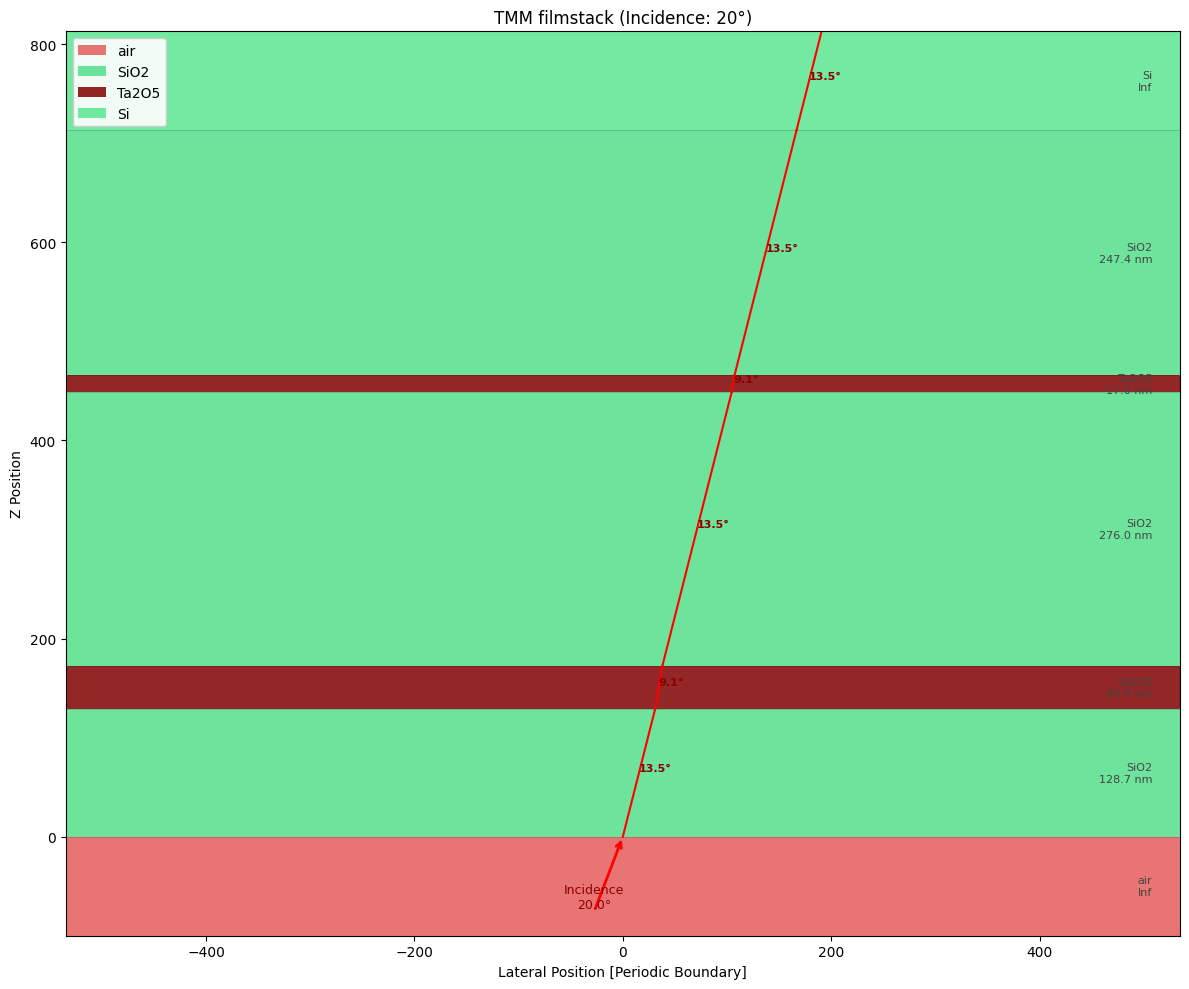

* test with wavelength=532, incidence=20
(E field)     	TE	TM
Reflectance  	[(0,0),(0.151625,0.13144),(0,0)]	[(0.148711,0.108135),(0,0),(0.0541263,0.0393578)]
Transmittance	[(0,0),(0.795205,0.0474183),(0,0)]	[(0.774796,0.027436),(0,0),(-0.186604,-0.00660777)]


In [17]:
OB_AR625_655(wl_0 = 532, angle = 20)

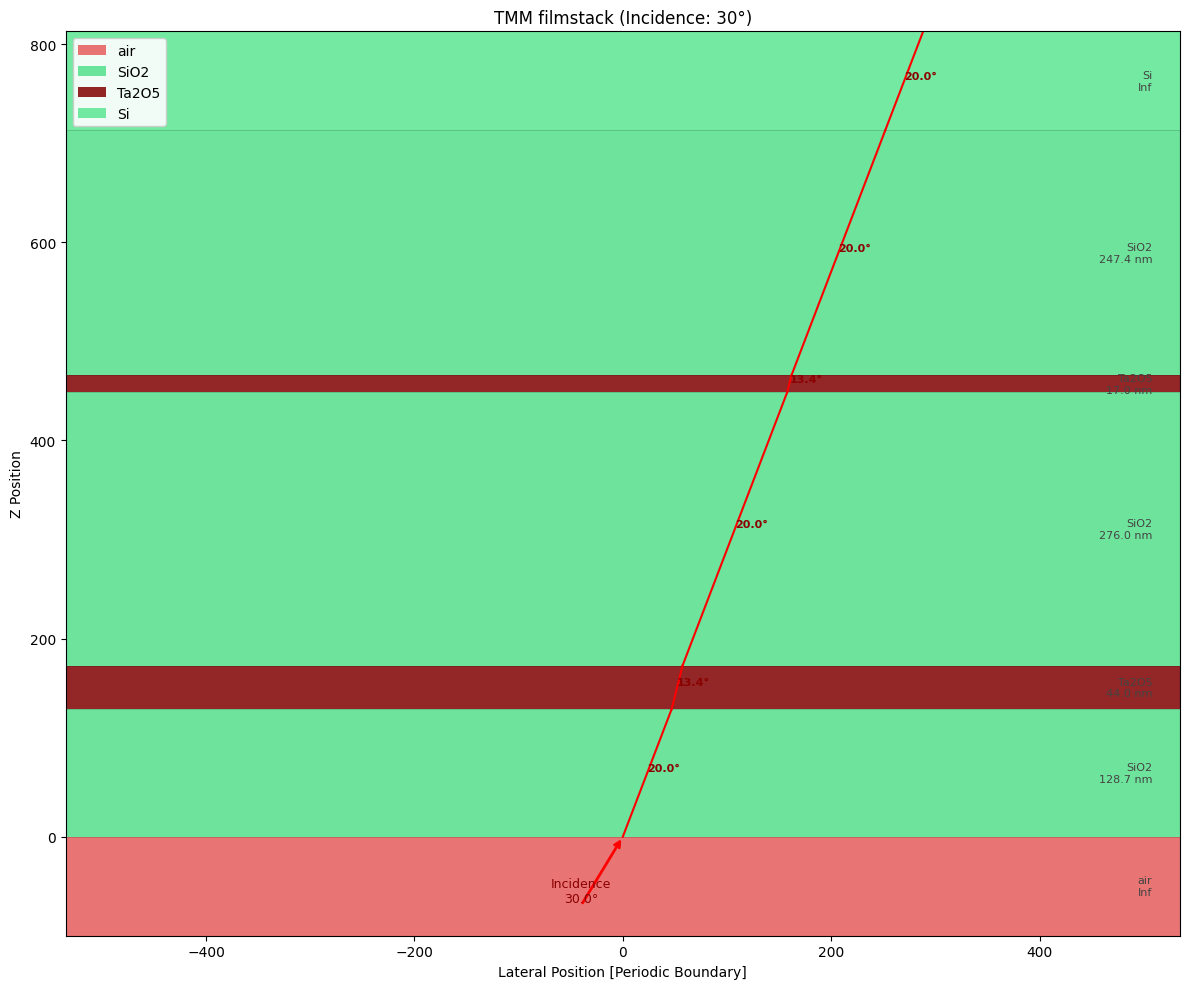

* test with wavelength=532, incidence=30
(E field)     	TE	TM
Reflectance  	[(0,0),(0.109032,0.0506767),(0,0)]	[(0.113167,0.0300969),(0,0),(0.0653373,0.0173765)]
Transmittance	[(0,0),(0.74353,-0.261885),(0,0)]	[(0.685811,-0.275988),(0,0),(-0.249848,0.100545)]


In [18]:
OB_AR625_655(wl_0 = 532, angle = 30)

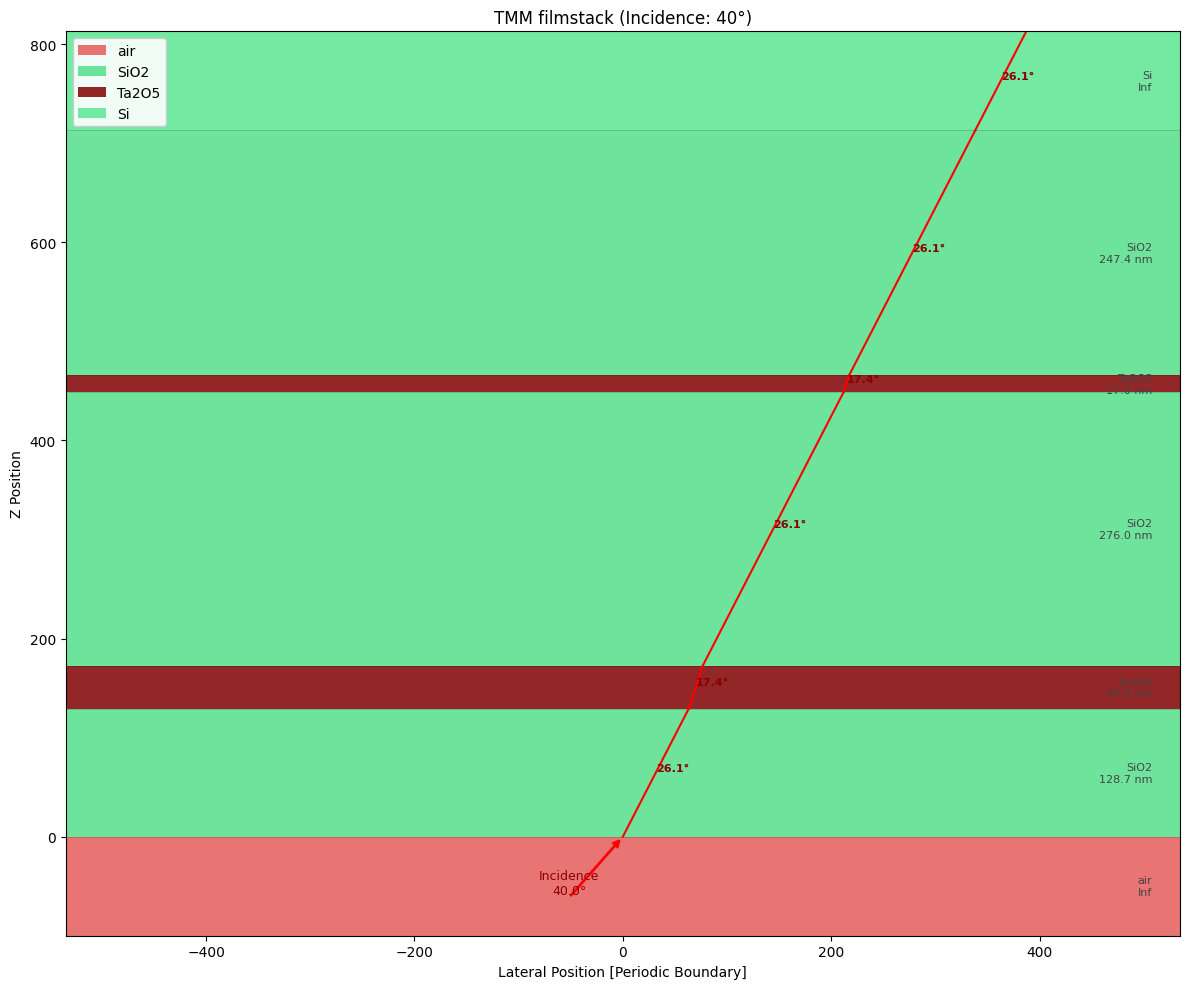

* test with wavelength=532, incidence=40
(E field)     	TE	TM
Reflectance  	[(0,0),(0.0156374,-0.00802791),(0,0)]	[(0.0695627,-0.00630492),(0,0),(0.05837,-0.00529046)]
Transmittance	[(0,0),(0.504001,-0.573932),(0,0)]	[(0.42054,-0.538377),(0,0),(-0.206087,0.263834)]


In [19]:
OB_AR625_655(wl_0 = 532, angle = 40)

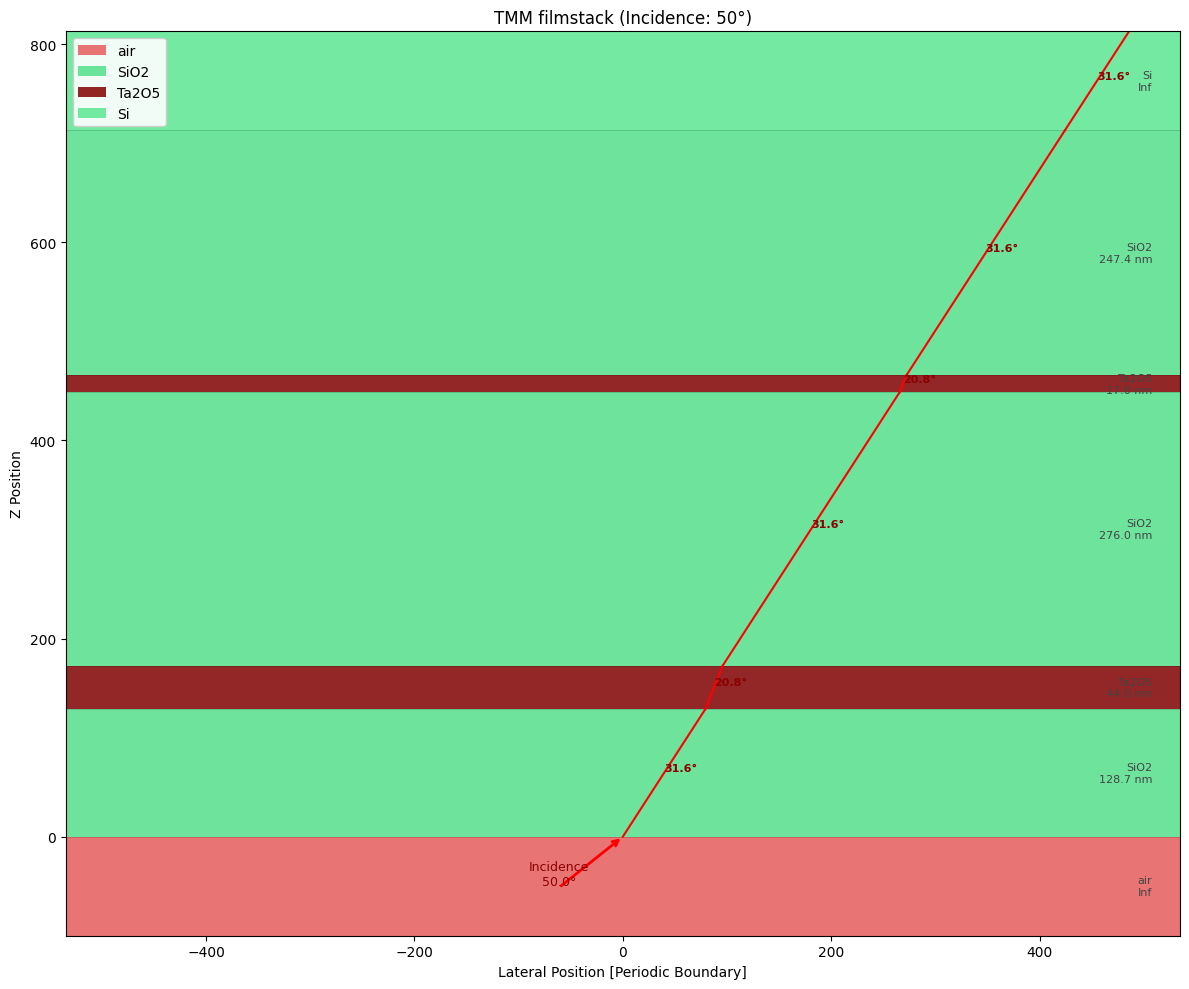

* test with wavelength=532, incidence=50
(E field)     	TE	TM
Reflectance  	[(0,0),(-0.0957898,-0.00579744),(0,0)]	[(0.0594608,-0.000720558),(0,0),(0.0708627,-0.000858728)]
Transmittance	[(0,0),(0.108015,-0.70713),(0,0)]	[(0.0517758,-0.607088),(0,0),(-0.0318905,0.373926)]


In [20]:
OB_AR625_655(wl_0 = 532, angle = 50)

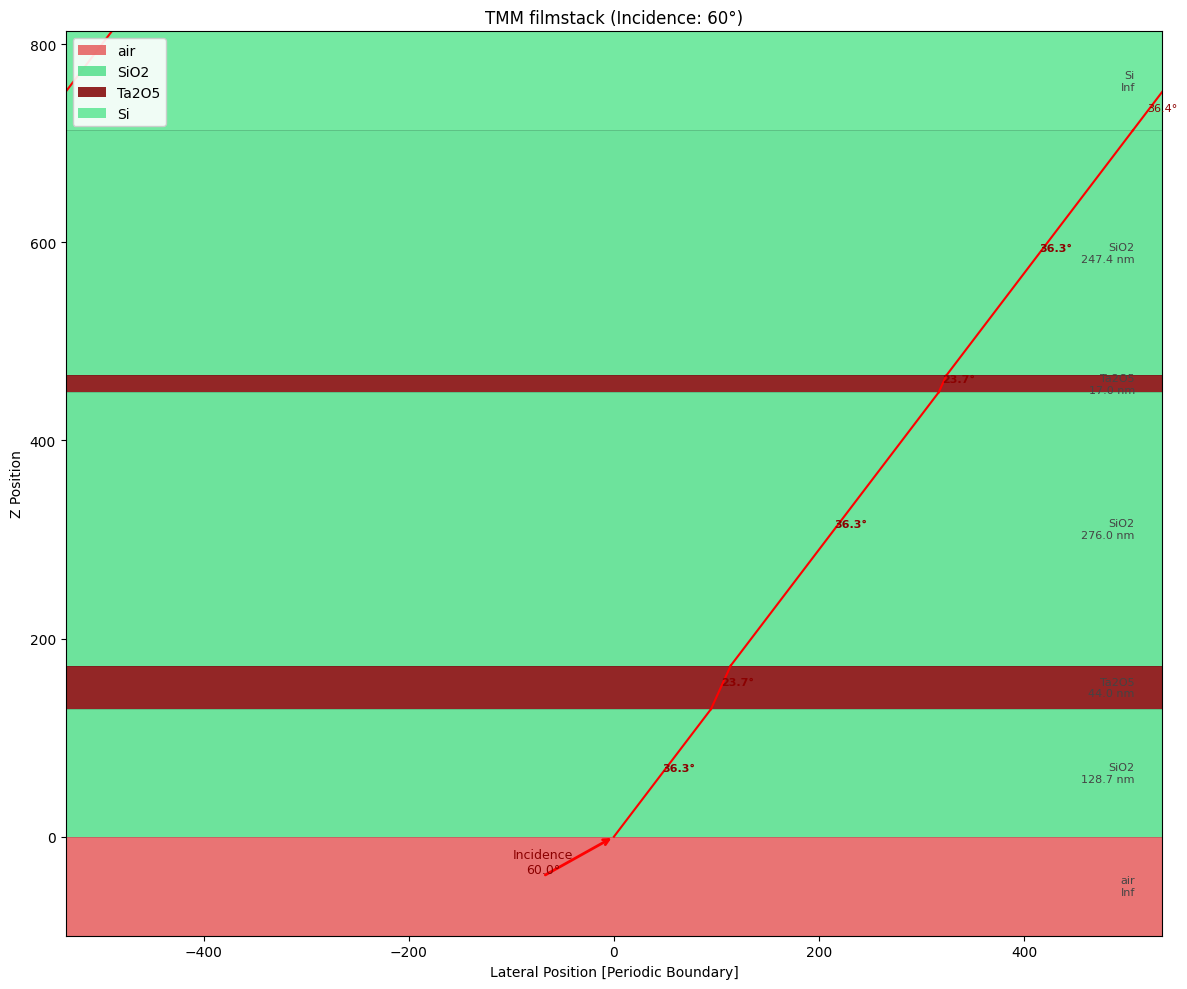

* test with wavelength=532, incidence=60
(E field)     	TE	TM
Reflectance  	[(0,0),(-0.180109,0.0330368),(0,0)]	[(0.0875206,0.00887665),(0,0),(0.15159,0.0153748)]
Transmittance	[(0,0),(-0.253225,-0.588555),(0,0)]	[(-0.240043,-0.457521),(0,0),(0.176729,0.336844)]


In [21]:
OB_AR625_655(wl_0 = 532, angle = 60)

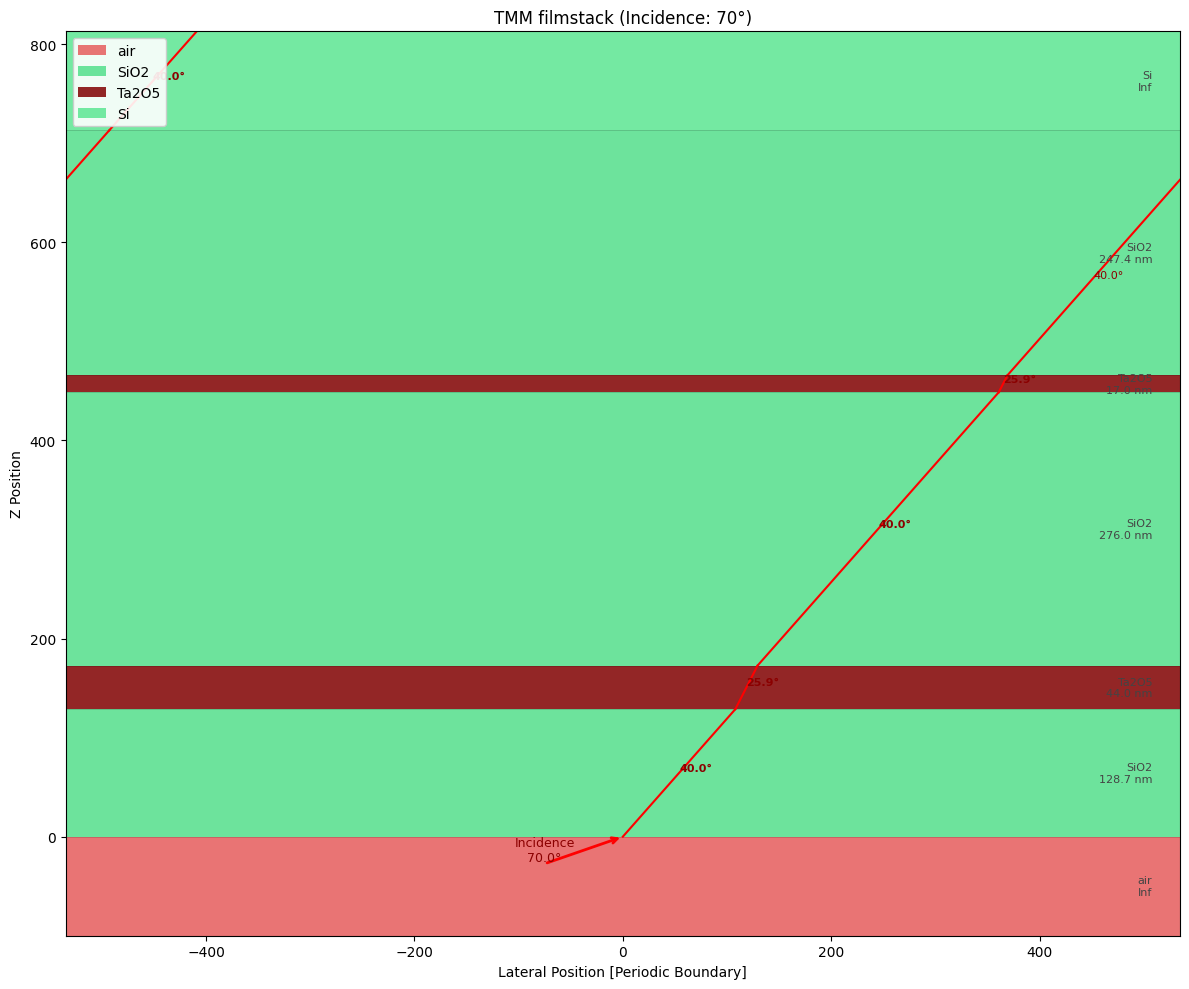

* test with wavelength=532, incidence=70
(E field)     	TE	TM
Reflectance  	[(0,0),(-0.266696,0.0461146),(0,0)]	[(0.11534,0.00539495),(0,0),(0.316894,0.0148225)]
Transmittance	[(0,0),(-0.412428,-0.336349),(0,0)]	[(-0.327859,-0.226357),(0,0),(0.275492,0.190203)]


In [22]:
OB_AR625_655(wl_0 = 532, angle = 70)

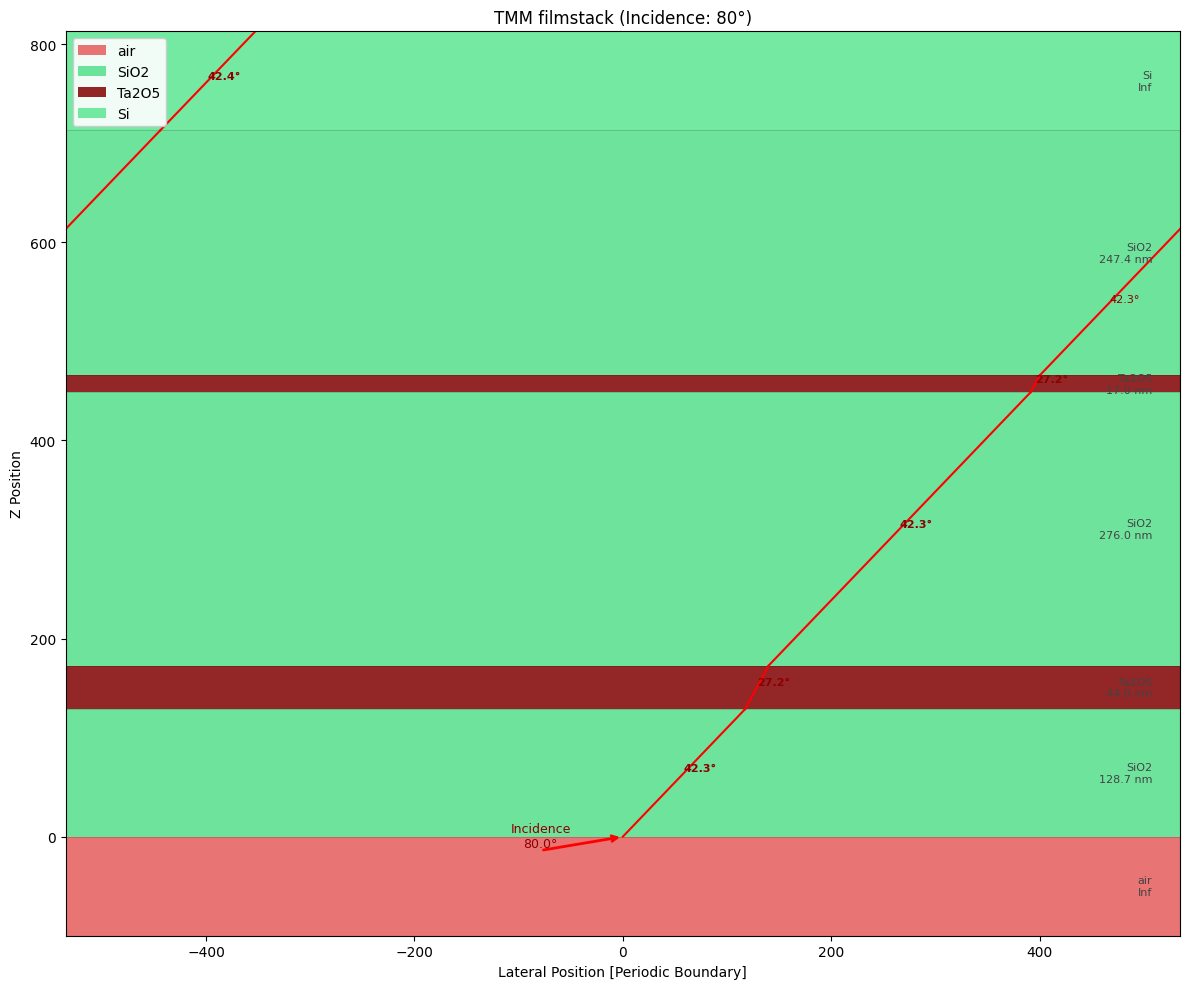

* test with wavelength=532, incidence=80
(E field)     	TE	TM
Reflectance  	[(0,0),(-0.476655,0.0194682),(0,0)]	[(0.102455,0.000556288),(0,0),(0.581053,0.00315486)]
Transmittance	[(0,0),(-0.331883,-0.118719),(0,0)]	[(-0.229742,-0.0664357),(0,0),(0.209727,0.0606477)]


In [23]:
OB_AR625_655(wl_0 = 532, angle = 80)

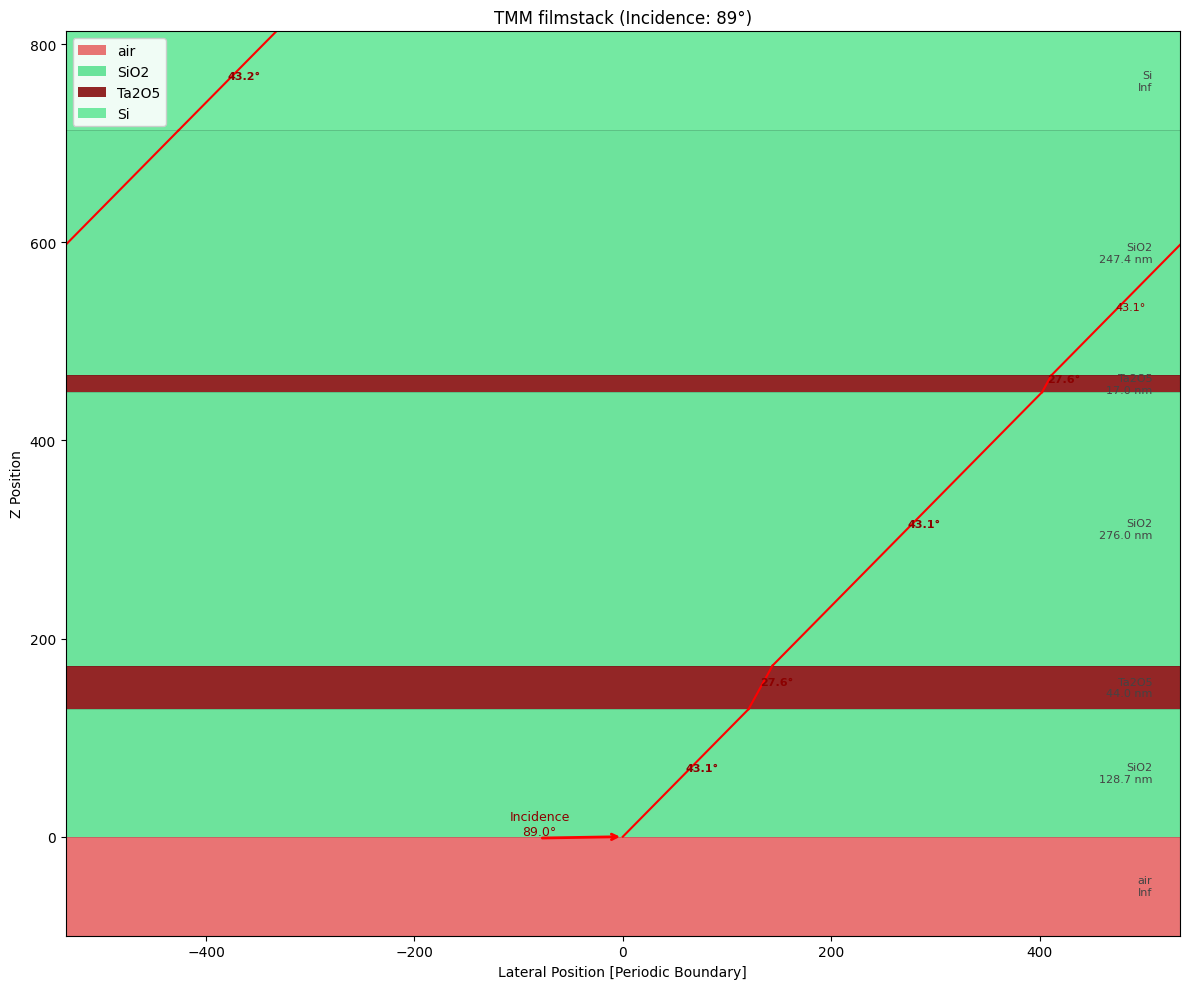

* test with wavelength=532, incidence=89
(E field)     	TE	TM
Reflectance  	[(0,0),(-0.926394,0.000967106),(0,0)]	[(0.0165596,-2.65627e-06),(0,0),(0.948744,-0.000152185)]
Transmittance	[(0,0),(-0.0470796,-0.0102728),(0,0)]	[(-0.0290143,-0.00501886),(0,0),(0.0272426,0.0047124)]


In [24]:
OB_AR625_655(wl_0 = 532, angle = 89)